# Analyze Ball on Incline data


In [1]:
# Imports
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import scipy.optimize
from scipy import stats
from sympy import * 
from IPython.core.display import Latex
from iminuit import Minuit
sys.path.append('External_Functions')
from ExternalFunctions import Chi2Regression

## 1.Theory

In [2]:
def lprint(*args,**kwargs):
    """Pretty print arguments as LaTeX using IPython display system 
    
    Parameters
    ----------
    args : tuple 
        What to print (in LaTeX math mode)
    kwargs : dict 
        optional keywords to pass to `display` 
    """
    display(Latex('$$'+' '.join(args)+'$$'),**kwargs)
    
# Define variables g and dg:
D_ball,d_rail,theta, Delta_theta, a, g = symbols("D_ball, d_rail, theta,Delta_theta,a,g")
dg,da,dtheta, dD_ball,dd_rail= symbols("sigma_g, sigma_a,sigma_theta, sigma_Dball, sigma_drail ")

#define g and dg
g = (a/sin(theta))*(1+(2*D_ball**2)/(5*(D_ball**2-d_rail**2/4)))
dg = sqrt((g.diff(a) * da)**2 + (g.diff(theta) * dtheta)**2+(g.diff(D_ball) * dD_ball)**2 + (g.diff(d_rail) * dd_rail)**2)

#create functions for g
fg =lambdify((a,theta,D_ball,d_rail),g)
fdg =lambdify((a,da,theta,dtheta,D_ball,dD_ball,d_rail,dd_rail),dg)
#print using sympy
print('g is given by the equation:')
lprint(latex(Eq(symbols('g'),g)))
print('The uncertanty on g is given by: ')
lprint(latex(Eq(symbols('dg'),dg)))




g is given by the equation:


<IPython.core.display.Latex object>

The uncertanty on g is given by: 


<IPython.core.display.Latex object>

The paramteres $D_{ball}$, $d_{rail}$, $\theta$ were meaured, the acceleration $a$ is calculated using the distance equation.

In [3]:
# Define variables distance and d_distance:
S,a,t, b, c = symbols("S, a, t,b,c")

#define distance and d_distance
S = a * t**2 + b * t + c

#create functions for distance
fd =lambdify((a,t,b,c),S)
print('The distance equation is given by:')
#print using sympy
lprint(latex(Eq(symbols('S'),S)))


The distance equation is given by:


<IPython.core.display.Latex object>

## 2.Calculating acceleration $a$
Acceleration is calculated using voltage and time measurments obtained in the lab.

### Functions

In [4]:
def read_csv(filename):
    """Read CSV from Waveforms"""
    dat = np.genfromtxt(filename, delimiter=',', skip_header=0, names=True)
    time = dat['Time_s'][10:]
    voltage = dat['Channel_1_V'][10:]
    return time, voltage

### Find_peaks
def gradient_peaks(voltage,time):
    """Takes voltage and times (measured) 
    returnsvoltage gradient, peak of gradient indices, peak gradient time, condition"""
    dV = np.gradient(voltage)
    condition = dV>0
    peak_index = find_peaks(dV,.1)[0]
    times_grad = time[peak_index]
    return dV, peak_index, times_grad,condition



## Reading the data

The function "read_csv(filename)" takes in a filename and returns numpy arrays with time and voltage.

In [5]:
# Read in the data (1 file test)
file_balls = 'ball_time measurments/morten1.csv'
file_noise = 'noise/noise1.csv'
time, balls_voltage = read_csv(file_balls)
noise_time,noise_voltage = read_csv(file_noise)
voltage = balls_voltage - np.mean(noise_voltage)

In [6]:
### find peak gradient 
dV, peak_index, times_grad,condition = gradient_peaks(voltage,time)
print(f"""Gradient peaks times: {np.round(times_grad,3)},
\nwith a voltage:{np.round(voltage[peak_index],3)},
\nand indices:{peak_index}""")

Gradient peaks times: [0.471 0.664 0.809 0.93  1.039],

with a voltage:[1.332 1.759 1.474 1.601 1.381],

and indices:[4847 5808 6533 7140 7687]


###  how are we presenting this plot?

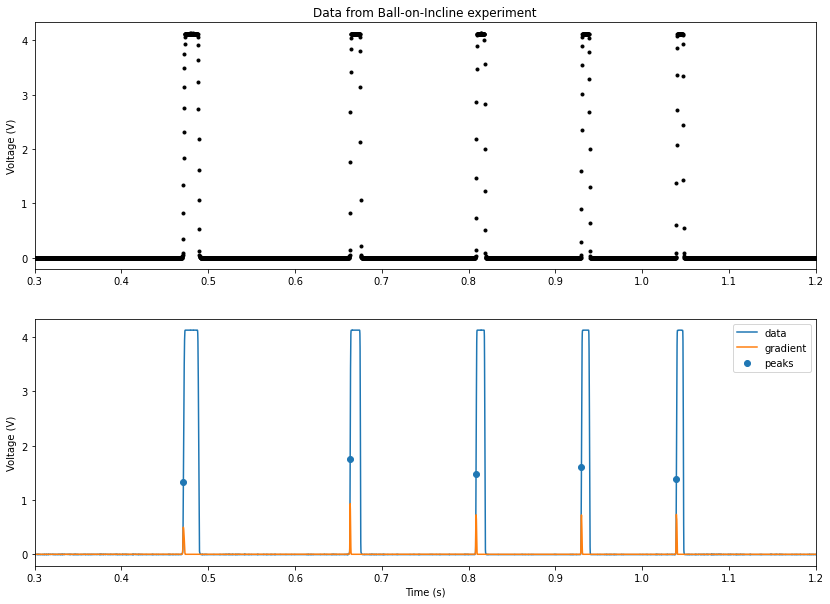

In [7]:
### Original data plot
fig, ax = plt.subplots(2,1, figsize=(14, 10))
ax[0].plot(time, voltage, 'k.', label='Measurements')
#ax.set_xlim(chi2_minpos-2*min_fit, chi2_minpos+2*max_fit)
ax[0].set_title("Data from Ball-on-Incline experiment")
ax[0].set_ylabel("Voltage (V)")
ax[0].set_xlim(0.3,1.2)

ax[1].plot(time,voltage,label='data')
ax[1].plot(time[condition],dV[condition], label='gradient')
ax[1].scatter(times_grad,voltage[peak_index],label='peaks')
ax[1].set_ylabel("Voltage (V)")
ax[1].set_xlabel("Time (s)")
ax[1].set_xlim(0.3,1.2)
ax[1].legend()
plt.show()

In [8]:
#get the mean of the noise, assuiming noise is gaussian
noise_list =[]
for i in range(1,7):
    file_noise = f'noise/noise{i}.csv'
    time, balls_voltage = read_csv(file_balls)
    noise_time,noise_voltage = read_csv(file_noise)
    noise_list.append(noise_voltage)
noise = np.concatenate(noise_list)
noise_mean = np.mean(noise)
noise_std = np.std(noise)
print(f'The noise is {noise_mean:1.3}  +/-  {noise_std:1.1}')

The noise is 0.835  +/-  0.002


In [9]:
#get the times of all the balls using peak gradients
ball_times_grad = np.zeros((30,5))

#loop throug files and add the times in each row of ball_times_grad
for i in range(1,31):
    file_balls = f'ball_time measurments/morten{i}.csv'
    time, balls_voltage = read_csv(file_balls)
    voltage = balls_voltage - noise_mean
    ### Find_peaks
    dV, peak_index, times_grad,condition = gradient_peaks(balls_voltage,time)
    ball_times_grad[i-1] = times_grad
ball_times_grad

array([[0.4714, 0.6636, 0.8086, 0.93  , 1.0394],
       [0.7538, 0.9458, 1.0904, 1.2116, 1.3208],
       [0.6848, 0.877 , 1.0222, 1.1436, 1.2528],
       [0.559 , 0.7508, 0.8954, 1.0166, 1.1258],
       [0.6394, 0.832 , 0.9774, 1.0992, 1.2088],
       [0.2714, 0.464 , 0.6092, 0.7306, 0.84  ],
       [0.6428, 0.835 , 0.98  , 1.1014, 1.2108],
       [1.1054, 1.2972, 1.442 , 1.5634, 1.6728],
       [0.91  , 1.1032, 1.2488, 1.3704, 1.4798],
       [0.461 , 0.6524, 0.797 , 0.9182, 1.0272],
       [0.354 , 0.5454, 0.6898, 0.8112, 0.9202],
       [0.3628, 0.554 , 0.6988, 0.8198, 0.9288],
       [1.5218, 1.7116, 1.8558, 1.9766, 2.0854],
       [0.642 , 0.8348, 0.98  , 1.102 , 1.2116],
       [0.6086, 0.7988, 0.943 , 1.064 , 1.173 ],
       [0.5328, 0.7244, 0.8692, 0.9906, 1.0996],
       [0.3822, 0.5734, 0.718 , 0.8392, 0.9482],
       [1.7352, 1.927 , 2.0718, 2.1932, 2.3026],
       [0.9092, 1.1002, 1.2446, 1.3658, 1.475 ],
       [0.971 , 1.164 , 1.3092, 1.4306, 1.54  ],
       [1.514 , 1.70

In [10]:
#get the first time at time zero.does this make sense? 
grad_times = np.zeros(((30,5)))
for i in range(5):
    grad_times[:,i] = ball_times_grad[:,i] - ball_times_grad[:,0]
grad_times
times = np.mean(grad_times,axis =0)
error_times = np.std(grad_times,axis=0)
print(f"""The mean the time measurments obtained using the gradient are:
{np.round(times,4)} [s]\n 
with std:\n{np.round(error_times,4)}[s]""") #is np.std the correct form to get the error?
      

The mean the time measurments obtained using the gradient are:
[0.     0.1916 0.3364 0.4577 0.5669] [s]
 
with std:
[0.     0.0008 0.0012 0.0014 0.0017][s]


In [11]:
#get all sensor positions
def read_csv_lenghts(filename):
    """Read CSV from Waveforms"""
    dat = np.genfromtxt(filename, delimiter=',', skip_header=0, names=True)
    lenghts = np.zeros((4,5))
    lenghts[:,0] = dat['Length1']
    lenghts[:,1] = dat['Length2']
    lenghts[:,2] = dat['Length3']
    lenghts[:,3] = dat['Length4']
    lenghts[:,4] = dat['Length5']
    Uncertanty = dat['Uncertainty']
    return lenghts, Uncertanty
#lenghts, Uncertanty = read_csv_lenghts('sensors_positions.csv')
lengths, uncertainties = read_csv_lenghts('sensors_positions.csv')
for i in range(len(uncertainties)):
    print(f'length {i+1}:\n{lengths[i]} +/- {uncertainties[i]} [cm]')

length 1:
[26.  41.3 56.4 71.2 86.8] +/- 0.2 [cm]
length 2:
[25.1  41.2  55.15 72.5  85.3 ] +/- 0.02 [cm]
length 3:
[23.25 38.4  53.45 69.4  83.65] +/- 0.025 [cm]
length 4:
[23.275 38.475 53.475 68.425 83.7  ] +/- 0.005 [cm]


In [12]:
lengths_mean = np.mean(lengths,0)
print(f'mean of lengths:\n{np.round(lengths_mean,2)}    [cm]')
#starting from zero, in meters
length = (lengths_mean - lengths_mean[0])*1e-2
print(f'mean normalized length in meters:\n{np.round(length,2)}    [cm]')
len_uncertainty = np.mean(uncertainties)  # again is this the right way to get the uncertanty? 
print(f'uncertanty on the lenght:\n{np.round(len_uncertainty,2)}    [cm]')

mean of lengths:
[24.41 39.84 54.62 70.38 84.86]    [cm]
mean normalized length in meters:
[0.   0.15 0.3  0.46 0.6 ]    [cm]
uncertanty on the lenght:
0.06    [cm]


In [13]:
#I couldnt get S lambdify function to work 
def distance(t,acc,b,c):
    return acc * t**2 + b*t + c

In [14]:
#fit the funtion using scipy
fit_parameters,pvoc = scipy.optimize.curve_fit(distance, times,length)
print(f'a*t^2+b*t+c:{fit_parameters}')
print(pvoc)

a*t^2+b*t+c:[ 7.02939041e-01  6.72421248e-01 -3.40610568e-04]
[[ 3.59228671e-03 -2.02164477e-03  1.38697563e-04]
 [-2.02164477e-03  1.24123038e-03 -1.10194985e-04]
 [ 1.38697563e-04 -1.10194985e-04  1.94462533e-05]]


In [17]:
#fit function using iminuit
Minuit.print_level = 0  
#takes the function, data points, the result distance? the error on the distance?
chi2_object = Chi2Regression(distance,times,length,len_uncertainty)
chi2_object.errordef = 0.1 #definition

#Here we let Minuit know, what to minimise, how, and with what starting parameters, shite example? 
minuit = Minuit(chi2_object,acc =0,b=0,c=0)
#perform the fit
minuit.migrad()
#extractfit
acc_fit = minuit.values['acc']
error_acc = minuit.errors['acc']
b_fit = minuit.values['b']
error_b = minuit.errors['b']
c_fit = minuit.values['c']
error_c = minuit.errors['c']

# Get the minimal value obtained for the quantity to be minimised (here the Chi2)
chi2_fit = minuit.fval
ndof = len(times) - minuit.nfit
prob_fit = stats.chi2.sf(chi2_fit,ndof)

#array with accelearation, b and c paramteres
minuit_fit = np.array([acc_fit,b_fit,c_fit])
minuit_fit_errors = np.array([error_acc,error_b,error_c])
print(f'a*t^2+b*t+c:{minuit_fit}\nwith respectuve erorros {minuit_fit_errors}')

a*t^2+b*t+c:[ 7.02939039e-01  6.72421249e-01 -3.40610733e-04]
with respectuve erorros [0.26127796 0.15358313 0.01922362]


In [18]:
## plot scypi optimize
y_fit_grad = distance(times,*fit_parameters)
plt.figure(figsize=(10,7))
plt.errorbar(grad_times[0], length, uncertainty,linestyle=':',color='tab:blue', label ='normalized mean length')
plt.plot(grad_times[0], y_fit_grad,color='tab:red', label = 'fit')
plt.legend()
plt.title('Time vs Disatnce')
plt.xlabel('time[s]')
plt.ylabel('distnace[cm]')
plt.show()

NameError: name 'uncertainty' is not defined

<Figure size 720x504 with 0 Axes>

In [19]:
#from distance formula 
acceleration_grad = 2*fit_parameters[0]
acceleration_iminuit = 2*minuit_fit[0]
error_acceleration = 2*minuit_fit_errors[0] #a_std = d(acceleration_iminuit)*acc_error
print(f'The acceleration of the ball using scipy optimize is:\n{acceleration_grad:1.4} [m/s^2]')  #get uncertanty
print(f'The acceleration of the ball using iminuit is:\n{acceleration_iminuit:1.2} +/- {error_acceleration:1.1}[m/s^2]')

The acceleration of the ball using scipy optimize is:
1.406 [m/s^2]
The acceleration of the ball using iminuit is:
1.4 +/- 0.5[m/s^2]


## 3. Calcuate g

### Experimental data

In [20]:
# data from dat spreadsheet
ball_diameter = np.array([1.2700,1.2700,1.2600,1.2800])*1e-2 # metre [m]
uncertanty_ball_diameter = 0.01*1e-2  #metre[m]
ball_diameter_mean = np.mean(ball_diameter)
print(f'mean ball diameter:\n{ball_diameter_mean:.3f} +/- {np.std(ball_diameter):1.3} [m]')


rail = np.array([0.62, 0.61, 0.61, 0.6])*1e-2
rail_mean = np.mean(rail)
print(f'rail mean:\n{rail_mean:.3f} =/- {np.std(rail):1.3} [m]')


# experiemental setup orientation 1
print()
angle1 = 90-np.array([76.9000 , 76.8000 , 77.0000 , 76.9000])
angle2 = np.array([103.5000, 103.5000, 103.7000, 103.6000])-90
mean_orientation1 = np.mean(np.array([[angle1],[angle2]]),0)
print(f'angles for orientation 1:\n{angle1}\n{angle2}')
print(f'with mean:\n{mean_orientation1}')
# experiemental setup orientation 2
print()
angle3 = np.array([104.1000, 104.1000, 104.2000, 104.2000])-90
angle4 = 90-np.array([75.8000 , 75.9000 , 75.8000 , 75.8000])
mean_orientation2 = np.mean(np.array([[angle3],[angle4]]),0)
print(f'angles for orientation 2:\n{angle3}\n{angle4}')
print(f'with mean:\n{mean_orientation2}')
print()
print(f'total mean angle:\n{np.mean(np.array([[mean_orientation2],[mean_orientation2]]))}')
angle = np.mean(np.array([[mean_orientation2],[mean_orientation2]]))

angle_uncertainty = np.array([1, 0.1, 0.05, 0.1])
mean_angle_uncert = np.mean(angle_uncertainty)

from math import sin, pi, atan
sin_angle = sin(angle*pi/180) #* 180/pi there was a big error from here, angle maybe a huge source of uncertanty 
print(f'sine angle: {sin_angle}')


mean ball diameter:
0.013 +/- 7.07e-05 [m]
rail mean:
0.006 =/- 7.07e-05 [m]

angles for orientation 1:
[13.1 13.2 13.  13.1]
[13.5 13.5 13.7 13.6]
with mean:
[[13.3  13.35 13.35 13.35]]

angles for orientation 2:
[14.1 14.1 14.2 14.2]
[14.2 14.1 14.2 14.2]
with mean:
[[14.15 14.1  14.2  14.2 ]]

total mean angle:
14.1625
sine angle: 0.24467283288538885


In [21]:
#calculate gravity using fg
gravity = fg(acc_fit*2,(angle*pi/180),ball_diameter_mean,rail_mean)
           

In [22]:
# NIST true gravity [ m/s^(-2) ]
gravity_true = 9.80665

In [23]:
print(f'gravity from data:{gravity:1.4}')  # get uncertanty 
print(f'procentage difference from true gravity:{round(abs((gravity-gravity_true)/gravity_true)*100,2)}%')

gravity from data:8.185
procentage difference from true gravity:16.54%


## Test different accelerations

In [24]:
inicial = acceleration_iminuit - error_acceleration
final = acceleration_iminuit + error_acceleration
acc = np.linspace(inicial,final,10)
grav =[]
for a in acc:
    grav.append(fg(a,(angle*pi/180),ball_diameter_mean,rail_mean))
grav    

[5.142690970292398,
 5.8187607947423166,
 6.494830619192236,
 7.170900443642154,
 7.846970268092072,
 8.523040092541992,
 9.19910991699191,
 9.875179741441828,
 10.551249565891746,
 11.227319390341666]

In [25]:
acc[7]

1.6961869181851363